In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-08-09 12:15:30.097637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 12:15:30.189371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 12:15:30.228547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 12:15:30.241627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 12:15:30.305516: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1723173332.128954     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723173332.244217     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723173332.244254     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import re
import fasttext

# 데이터 호출 및 파악

In [3]:
df = pd.read_csv('./datasets/ratings.txt', sep='\t', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)
df = df[['document', 'label']]
df.columns=['text','label']

In [4]:
df['label'].value_counts()

label
1    99996
0    99996
Name: count, dtype: int64

In [5]:
def replace_space(sentence):
    new = "".join(["" if ch == " " else ch for ch in sentence])
    return new

In [6]:
# df['text'] = df['text'].apply(replace_space)

In [7]:
df

,text,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
199987,포켓 몬스터 짜가 ㅡㅡ;;,0
199988,쓰.레.기,0
199989,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199990,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [8]:
def is_only_dots(s):
    return all(char == '.' for char in s)

In [9]:
def is_only_space(s):
    return all(char == ' ' for char in s)

In [10]:
def is_only_space_hangul(s):
    return all(ord(char) == 12644 for char in s)

In [11]:
df.shape

(199992, 2)

In [12]:
# dot만 포함하는 row
df = df[~df['text'].apply(is_only_dots)]

In [13]:
df.shape

(199816, 2)

In [14]:
df = df[~df['text'].apply(is_only_space)]

In [15]:
df.shape

(199816, 2)

In [16]:
df = df[~df['text'].apply(is_only_space_hangul)]

In [17]:
df.shape

(199816, 2)

In [18]:
df = df.reset_index(drop=True)

In [19]:
# 테스트를 위해 1만개만 샘플링
df = df.sample(n=len(df))
df = df.reset_index(drop=True)
# df = df[:20000]

In [20]:
df.shape

(199816, 2)

In [21]:
df

,text,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
199811,포켓 몬스터 짜가 ㅡㅡ;;,0
199812,쓰.레.기,0
199813,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199814,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [22]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

Normal speech counts :99886 (49.99%)
Hate speech counts :99930 (50.01%)


최대 길이 : 142
최소 길이 : 1
리뷰의 평균 길이 : 35.24269327781559


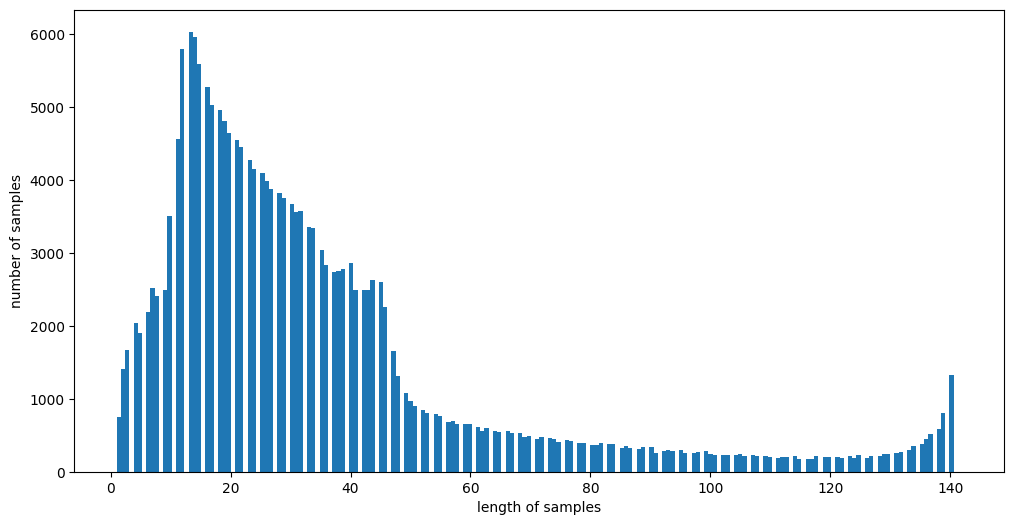

In [23]:
plt.figure(figsize=(12, 6))
print('최대 길이 :', max(len(text) for text in df['text']))
print('최소 길이 :', min(len(text) for text in df['text']))
print('리뷰의 평균 길이 :', sum(df['text'].str.len())/len(df))
plt.hist([len(text) for text in df['text']], bins=200)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [25]:
threshold = 35

In [26]:
below_threshold_len(threshold, df['text'])

전체 샘플 중 길이가 35 이하인 샘플의 비율: 65.53379108780078


In [27]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

Normal speech counts :99886 (49.99%)
Hate speech counts :99930 (50.01%)


In [28]:
# threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# threshold보다 문장이 길면 슬라이싱을 함
def add_cut_sentence(sentence, threshold):
    cut_list = []
    if len(sentence) >= threshold:
        cut_list = sentence[:threshold]
    else:
        while True:
            if len(cut_list) >= threshold:
                cut_list = cut_list[:threshold]
                break
            cut_list += sentence
    return "".join(cut_list)

In [29]:
# threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# threshold보다 문장이 길면 슬라이싱을 함
def cut_sentence(sentence, threshold):
    cut_list = []
    cut_list = sentence[:threshold]
    return cut_list

In [30]:
# df['text'] = df['text'].apply(lambda text: add_cut_sentence(text, threshold))

In [31]:
# df['text'] = df['text'].apply(lambda text: cut_sentence(text, threshold))

In [32]:
df

,text,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
199811,포켓 몬스터 짜가 ㅡㅡ;;,0
199812,쓰.레.기,0
199813,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199814,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [33]:
df.shape

(199816, 2)

# 이미지화

In [34]:
# 이미지로 변환하는 함수
def create_sentence_image(sentence, font_path, font_size, background_color=(0, 0, 0), text_color=(255, 255, 255)):
  sentence_split = sentence.split('\n')
  width = len(max(sentence_split, key=len)) # 길이가 가장 긴 리스트의 길이로 너비 결정
  height = len(sentence_split) # 개행으로 나눠진 리스트의 길이로 높이 결정

  image_width, image_height = (width*16), height*24  # 픽셀 사이즈 조정
  image = Image.new('RGB', (image_width, image_height), background_color)
  draw = ImageDraw.Draw(image)

  # 폰트 호출
  font = ImageFont.truetype(font_path, font_size)

  # Get the text size
  # text_width, text_height = draw.textlength(sentence, font=font)
  _, _, text_width, text_height = draw.textbbox((0, 0), sentence, font=font)

  # Calculate the position to center the text
  x = (image_width - text_width) // 2
  y = (image_height - text_height) // 2

  # Draw the letter on the image
  draw.text((x, y), sentence, font=font, fill=text_color)

  # Convert image to numpy array
  img_array = np.array(image)

  # Find the bounding box of non-background pixels
  non_background = np.where(img_array != background_color)
  top, left = np.min(non_background[0]), np.min(non_background[1])
  bottom, right = np.max(non_background[0]), np.max(non_background[1])

  # Crop the image
  cropped_image = image.crop((left, top, right+1, bottom+1))

  return cropped_image

In [35]:
# 이미지 사이즈 조절. resize
def resize_image(img):
  resized_img = img.resize((32,32))
  return resized_img

In [36]:
# 폰트 설정
font_path = "./utils/arial-unicode.ttf"
font_size = 12

In [37]:
text = "안녕하세요???? 테스트 데이터입니다............."
# text = df['text'][2]
sample = replace_space(text)
# sample = text
img = create_sentence_image(str(sample), font_path, font_size)
resized_img = resize_image(img)
display(img)
img = np.array(img)

In [38]:
print(f"Y axis max value: {img.shape[0]}")
print(f"X axis max value: {img.shape[1]}")

Y axis max value: 11
X axis max value: 237


In [39]:
print(np.array(resized_img).shape)

(32, 32, 3)


# coordinates 추출

In [40]:
# convert image into coordinates
def get_coordinates(img):
  img_arr = np.array(img)
  coordinates = []
  for x in range(len(img_arr)):
    for y in range(len(img_arr[x])):
      if max(img_arr[x][y]) != 0:
        coordinates.append([y,x])
  return np.array(coordinates)

In [41]:
def extract_x_y(img_arr, coordinates):
  # x = np.array([point[0] for point in coordinates]) / len(img_arr[0])
  # y = np.array([point[1] for point in coordinates]) / len(img_arr)
  x = np.array([point[0] for point in coordinates])
  y = np.array([point[1] for point in coordinates])
  # y = 1-y
  return x, y

In [42]:
def draw_text(x, y):
  # plotting
  plt.scatter(x, y, color='blue')

  # Set plot title and labels
  plt.title('Coordinates for Sentence')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Display plot
  plt.show()

In [43]:
coordinates = get_coordinates(img)

In [44]:
coordinates.shape

(965, 2)

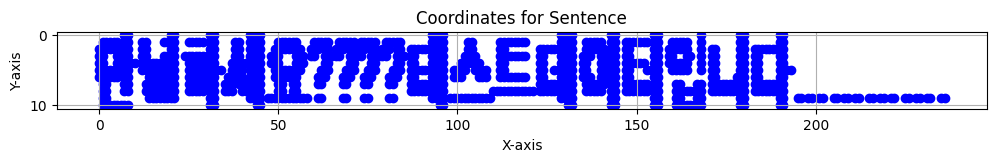

In [45]:
# plotting
import matplotlib.pyplot as plt

x, y = extract_x_y(img, coordinates)

plt.figure(figsize=(12, 1))
plt.scatter(x, y, color='blue')

# Set plot title and labels
plt.title('Coordinates for Sentence')
plt.gca().invert_yaxis()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)  # 그리드 추가

# Display plot
plt.show()

# 좌표값 정규화

In [46]:
def std_coordinates(data, max_x, max_y):
    standardized_data = np.zeros_like(data, dtype=float)
    standardized_data[:, 0] = data[:, 0] / max_x
    standardized_data[:, 1] = data[:, 1] / max_y
    return standardized_data

In [47]:
coordinates[300]

array([130,   3])

In [48]:
img.shape

(11, 237, 3)

In [49]:
std_coords = std_coordinates(coordinates, img.shape[1], img.shape[0])

In [50]:
std_coords.shape

(965, 2)

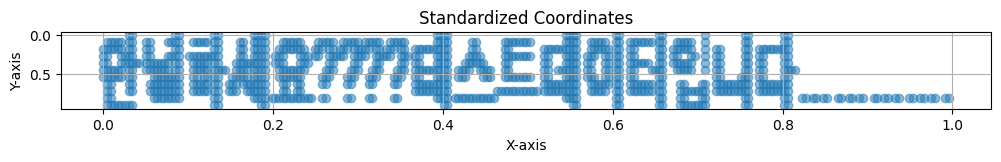

In [51]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(std_coords[:, 0], std_coords[:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

# 전처리

In [52]:
# 패딩
def pad_coords(coords, pad_size=3000):
    sorted_data = coords[coords[:, 0].argsort()]
    if len(sorted_data) >= pad_size:
        return sorted_data[:pad_size]
    else:
        diff = pad_size - len(sorted_data)
        sorted_data = np.pad(sorted_data, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return sorted_data

In [53]:
# stopwords 호출
with open('./datasets/stopwords.txt', 'r') as f:
    lines = f.readlines()

# lines = [line.strip() for line in lines]
stopwords = list([line.strip() for line in lines if line != ""][1:])

In [54]:
# fasttext 모델 load
fasttext_model = fasttext.load_model("fasttext_model.bin")

In [55]:
from konlpy.tag import Okt
okt = Okt()

In [56]:
def vectorize_text(morph_list, model):
    vectors = []
    for i in range(len(morph_list)):
        vectors.append(model[morph_list[i]])
    return vectors

In [57]:
def get_morphs(s):
    words = okt.morphs(s, norm=True)
    processed_words = [word for word in words if word not in stopwords]
    return processed_words

In [58]:
get_morphs('안녕?ㅎㅎ')

['안녕', '?', 'ㅎㅎ']

In [59]:
test = vectorize_text(get_morphs('안녕? ㅎㅎ 사랑해'), fasttext_model)

In [60]:
np.array(test[0]).shape

(100,)

In [61]:
test[3] == fasttext_model['사랑']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [62]:
vector_data = []
coords_data = []
img_data = []
coords_by_length = []
label_list = []

pad_size = 3000

for i in range(len(df)):
    text = df['text'][i]
    processed_text = get_morphs(text)
    vector_list = vectorize_text(processed_text, fasttext_model)
    if len(vector_list) == 0:
        continue
    else:
        vector_data.append(vector_list)
        # spaceless_text = replace_space(text)
        spaceless_text = replace_space(" ".join(processed_text))
        img = create_sentence_image(spaceless_text, font_path, font_size)
        resized_img = resize_image(img)
        img_data.append(resized_img)
        img = np.array(img)
        
        # 좌표 추출
        coordinates = get_coordinates(img)
        
        x_lim = img.shape[1]
        y_lim = img.shape[0]
        
        # 좌표 정규화
        std_coords = std_coordinates(coordinates, x_lim, y_lim)
        coords_by_length.append(std_coords.shape[0])
        padded_coords = pad_coords(std_coords, pad_size)
    
        coords_data.append(padded_coords)
        label_list.append(df['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(coords_data))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2c9b226370>>
Traceback (most recent call last):
  File "/home/sdm/miniconda3/envs/dl/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [63]:
df['text'][0]

'어릴때보고 지금다시봐도 재밌어요ㅋㅋ'

In [66]:
# display(img_data[0])

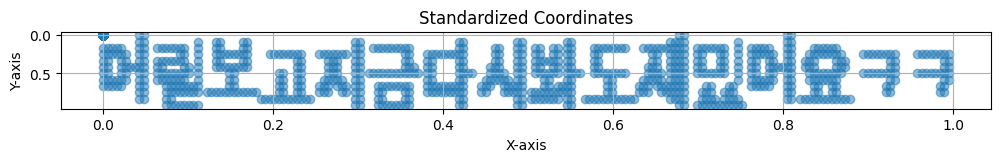

In [64]:
plt.figure(figsize=(12, 1))
plt.scatter(coords_data[0][:, 0], coords_data[0][:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.grid(True)

# 플롯 표시
plt.show()

In [65]:
# coords 평균 길이
max_len = max(i for i in coords_by_length)
min_len = min(i for i in coords_by_length)
average = sum(i for i in coords_by_length) / len(coords_by_length)

print("max length: ", max_len)
print("min length: ", min_len)
print("avg length: ", average)

max length:  10606
min length:  2
avg length:  1357.6970644117946


In [66]:
# vector 평균 길이
vec_max_len = max(len(i) for i in vector_data)
vec_min_len = min(len(i) for i in vector_data)
vec_average = sum(len(i) for i in vector_data) / len(vector_data)

print("max length: ", vec_max_len)
print("min length: ", vec_min_len)
print("avg length: ", vec_average)

max length:  95
min length:  1
avg length:  11.81343776061496


# 정규화

In [67]:
# vector 패딩
def pad_vector(vec, pad_size=30):
    padded = []
    if len(vec) >= pad_size:
        return np.array(vec[:pad_size])
    else:
        diff = pad_size - len(vec)
        padded = np.pad(vec, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return np.array(padded)

In [68]:
pad_vector(vector_data[0],50).shape

(50, 100)

In [69]:
# 벡터 제로패딩
padded_vector_data = []
for i in range(len(vector_data)):
    padded_vector_data.append(pad_vector(vector_data[i], 30))
padded_vector_data = np.array(padded_vector_data)

In [70]:
padded_vector_data.shape

(137895, 30, 100)

# 데이터 분할

In [71]:
# # 데이터 분할
x_train = padded_vector_data[:110000]
x_train_coords = np.array(coords_data)[:110000]
x_train_img = np.array(img_data)[:110000]
y_train = np.array(label_list)[:110000]

x_test = padded_vector_data[110000:]
x_test_coords = np.array(coords_data)[110000:]
x_test_img = np.array(img_data)[110000:]
y_test = np.array(label_list)[110000:]

print(x_train.shape)
print(x_train_coords.shape)
print(x_train_img.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test_coords.shape)
print(x_test_img.shape)
print(y_test.shape)

(110000, 30, 100)
(110000, 3000, 2)
(110000, 32, 32, 3)
(110000,)
(27895, 30, 100)
(27894, 3000, 2)
(27895, 32, 32, 3)
(27894,)


# 모델 설계

In [72]:
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Flatten, Dense, Concatenate, MaxPool2D, MaxPool1D, Dropout, LSTM, Embedding
from tensorflow.keras.models import Model, Sequential

In [ ]:
# # 벡터 입력
# vector_input = Input(shape=(30, 100))
# x1 = LSTM(128, activation='relu')(vector_input)

# # 결합
# img_input = Input(shape=(32,32,3))
# x2 = Conv2D(64, (3,3), activation='relu')(img_input)
# x2 = MaxPool2D()(x2)
# x2 = Dense(128, activation='relu')(x2)
# x2 = Flatten()(x2)

# # 결합
# combined = Concatenate()([x1, x2])
# x3 = Dense(512, activation='relu')(combined)
# output = Dense(1, activation='sigmoid')(x3)

# # 모델 정의
# model = Model(inputs=[vector_input, img_input], outputs=output)

In [73]:
# 벡터 입력
vector_input = Input(shape=(30, 100))
x1 = LSTM(128, activation='relu')(vector_input)
x1 = Flatten()(x1)

# 글자 좌표 입력
coords_input = Input(shape=(pad_size,2))
x2 = Dense(768, activation='relu')(coords_input)
x2 = Flatten()(x2)  # Flatten the output of Dense layer

# 결합
combined = Concatenate()([x1, x2])
x3 = Dense(128, activation='relu')(combined)
x3 = Dropout(0.4)(x3)
output = Dense(1, activation='sigmoid')(x3)

# 모델 정의
model = Model(inputs=[vector_input, coords_input], outputs=output)

I0000 00:00:1723189583.406852     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723189583.406959     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723189583.406971     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723189583.533718     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723189583.533794     954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-09

In [ ]:
# model = Sequential([
#     LSTM(128, input_shape=(30, 100)),
#     Dense(1, activation='sigmoid')
# ])

In [74]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    117,248 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3000, 768) │      2,304 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2304000)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2304128)   │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │ 294,928,5… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 295,048,193 (1.10 GB)

 Trainable params: 295,048,193 (1.10 GB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 5

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5


I0000 00:00:1723189613.301115   69017 service.cc:146] XLA service 0x7f23dc003f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723189613.301347   69017 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-09 16:46:53.337962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-09 16:46:53.493634: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-08-09 16:46:53.989952: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 20 bytes spill stores, 20 bytes spill loads

2024-08-09 16:46:54.010157: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function

   6/3094 ━━━━━━━━━━━━━━━━━━━━ 1:14 24ms/step - accuracy: 0.7703 - loss: 0.2849  

I0000 00:00:1723189615.181290   69017 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3093/3094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9984 - loss: 0.0019

2024-08-09 16:48:10.351312: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 20 bytes spill stores, 20 bytes spill loads

2024-08-09 16:48:10.384300: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 28 bytes spill stores, 28 bytes spill loads



3094/3094 ━━━━━━━━━━━━━━━━━━━━ 94s 26ms/step - accuracy: 0.9984 - loss: 0.0019 - val_accuracy: 0.0799 - val_loss: 510.8538
Epoch 2/5
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 76s 25ms/step - accuracy: 1.0000 - loss: 1.8217e-43 - val_accuracy: 0.0799 - val_loss: 510.8538
Epoch 3/5
1256/3094 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 1.0000 - loss: 5.6052e-45

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2c9b226370>>
Traceback (most recent call last):
  File "/home/sdm/miniconda3/envs/dl/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2c9b226370>>
Traceback (most recent call last):
  File "/home/sdm/miniconda3/envs/dl/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2c9b226370>>
Traceback (most recent call last):
  File "/home/sdm/miniconda3/envs/dl/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 7

In [99]:
# LSTM model
batch_size = 32
epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7472 - loss: 0.4924 - val_accuracy: 0.8200 - val_loss: 0.3914
Epoch 2/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8317 - loss: 0.3799 - val_accuracy: 0.8344 - val_loss: 0.3790
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8332 - loss: 0.3704 - val_accuracy: 0.8275 - val_loss: 0.3673
Epoch 4/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8363 - loss: 0.3613 - val_accuracy: 0.8375 - val_loss: 0.3669
Epoch 5/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8408 - loss: 0.3490 - val_accuracy: 0.8431 - val_loss: 0.3586


In [81]:
# Evaluate the model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7545112371444702
Test accuracy: 0.7830992937088013


In [100]:
# Evaluate LSTM
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36355993151664734
Test accuracy: 0.8367142677307129
